In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import utils

In [2]:
ROOT = r"C:\Users\ihett\OneDrive\Gabrilyi\leaflet_project\labeled\2_Ilyi_10102024"
IMAGE_DIR = os.path.join(ROOT, "images")
LABEL_DIR = os.path.join(ROOT, "labels")

In [3]:
image_path = os.path.join(IMAGE_DIR, os.listdir(IMAGE_DIR)[23])
label_path = os.path.join(LABEL_DIR, os.listdir(LABEL_DIR)[23])

image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image file '{image_path}' not found.")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [4]:
polygons = utils.read_polygons(label_path)
# print(polygons)

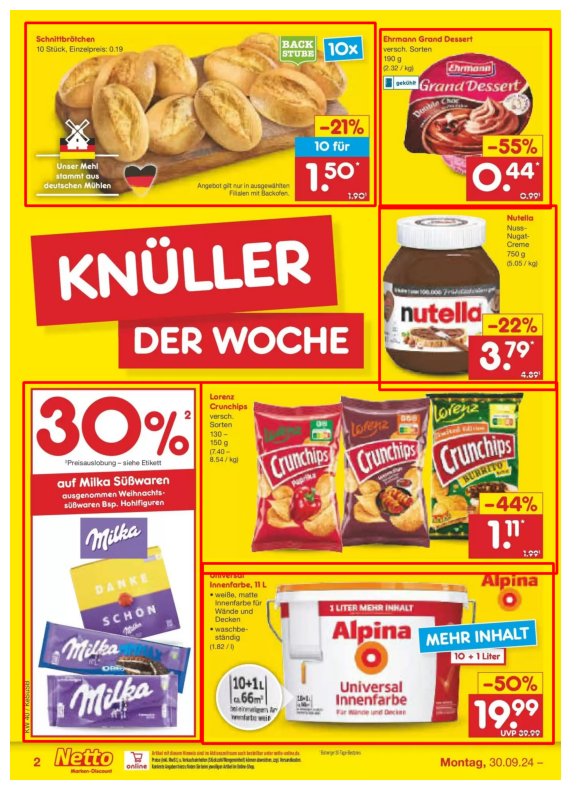

In [5]:
plot_img = image.copy()
for class_id, polygon in polygons:
    points = polygon.astype(int)
    cv2.polylines(plot_img, [points], isClosed=True, color=(255,0,0), thickness=5)

# Display the image with annotations
plt.figure(figsize=(10, 10))
plt.imshow(plot_img)
plt.axis('off')
plt.show()

In [6]:
def extract_polygons(image, polygons):
    """
    Extracts and crops regions defined by polygons from an image.

    Args:
        image (numpy.ndarray): The source image.
        polygons (list): A list of tuples, where each tuple contains a class ID and a polygon 
                         (as a numpy array of normalized coordinates).

    Returns:
        list: A list of cropped images containing the extracted polygons.
    """
    results = []
    for class_id, polygon in polygons:
        points = polygon.astype(int)

        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, [points], color=255)
        extracted = cv2.bitwise_and(image, image, mask=mask)

        x, y, w, h = cv2.boundingRect(points)

        cropped = extracted[y:y+h, x:x+w]
        results.append(cropped)

    return results


extracted = extract_polygons(image, polygons)

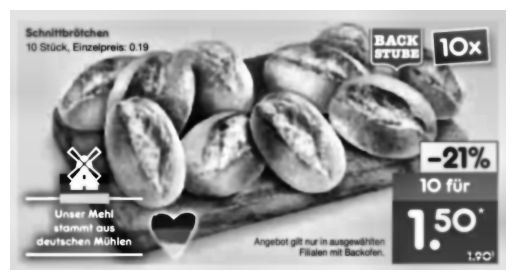

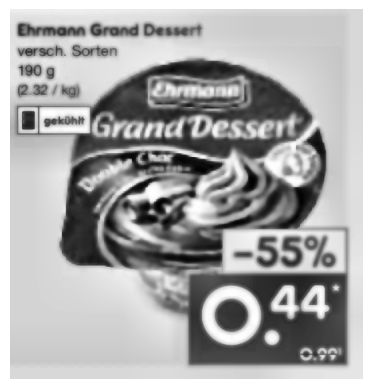

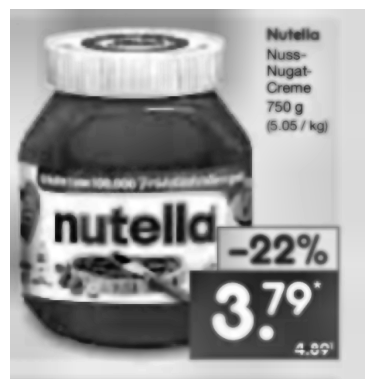

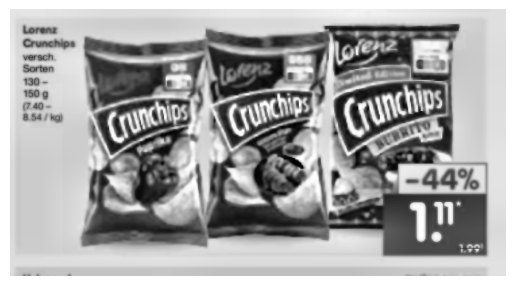

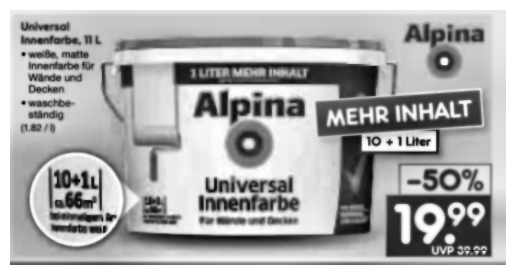

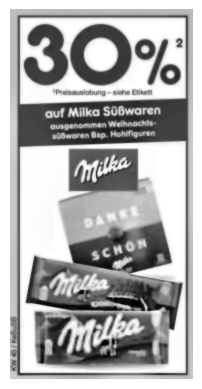

In [7]:
import cv2
import numpy as np

def preprocess(image):
    """
    Advanced preprocessing pipeline for OCR:
    1. Grayscale conversion
    2. Noise reduction with bilateral filtering
    3. Adaptive contrast enhancement (CLAHE)
    4. Morphological operations for text clarity
    5. Adaptive thresholding for binarization
    6. Dilation to enhance text structure
    """
    
    # Load image in grayscale
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    elif len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply bilateral filter (removes noise while preserving edges)
    image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    image = clahe.apply(image)

    # Morphological operations to remove small noise
    kernel = np.ones((2,2), np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=1)

    # Adaptive thresholding for optimal binarization
    # image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C,\
    #         cv2.THRESH_BINARY,11,2)
    # Otsu with gaussian
    # blur = cv2.GaussianBlur(image,(5,5),0)
    # _, image = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Dilation to strengthen text structure
    kernel = np.ones((1,1), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)

    return image

binaries = []
for ext in extracted:
    binary = preprocess(ext)
    plt.imshow(binary, cmap='gray')
    plt.axis('off')
    plt.show()
    binary = cv2.merge([binary, binary, binary])
    binaries.append(binary)

## OCR

In [8]:
# from paddleocr import PaddleOCR, draw_ocr
# from PIL import Image

# ocr = PaddleOCR(use_angle_cls=True, lang="de")

# for i, ext in enumerate(binaries):
#     result = ocr.ocr(ext, cls=True)
#     result = result[0]
#     boxes = [line[0] for line in result]
#     txts = [line[1][0] for line in result]
#     scores = [line[1][1] for line in result]
#     im_show = draw_ocr(ext, boxes, txts, scores, font_path="../assets/simfang.ttf")
#     plt.figure(figsize=(15, 15))
#     plt.imshow(im_show)
#     plt.axis('off')
#     plt.show()


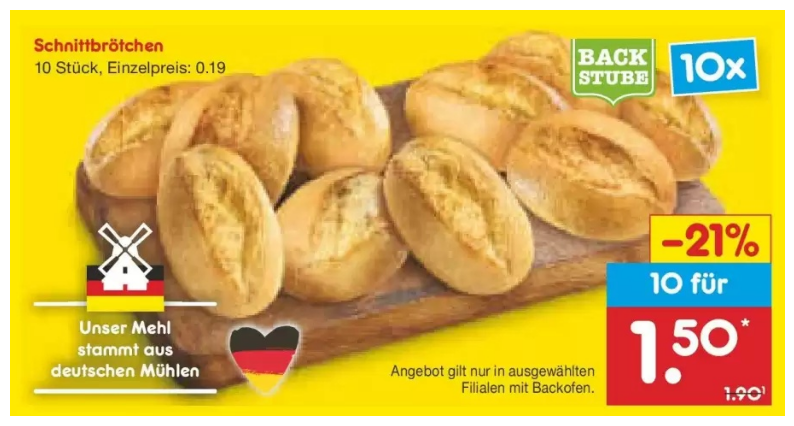

['Schnittbrötchen', '10 Stück, Einzelpreis: 0.19', 'BACK', 'IOx', 'STUBV', '~21%', '10 für', 'Unser Mehl', 'stammt aus', '150', 'deutschen Mühlen', 'Angebot gilt nur in ausgewählten', 'Filialen mit Backofen .', '489']


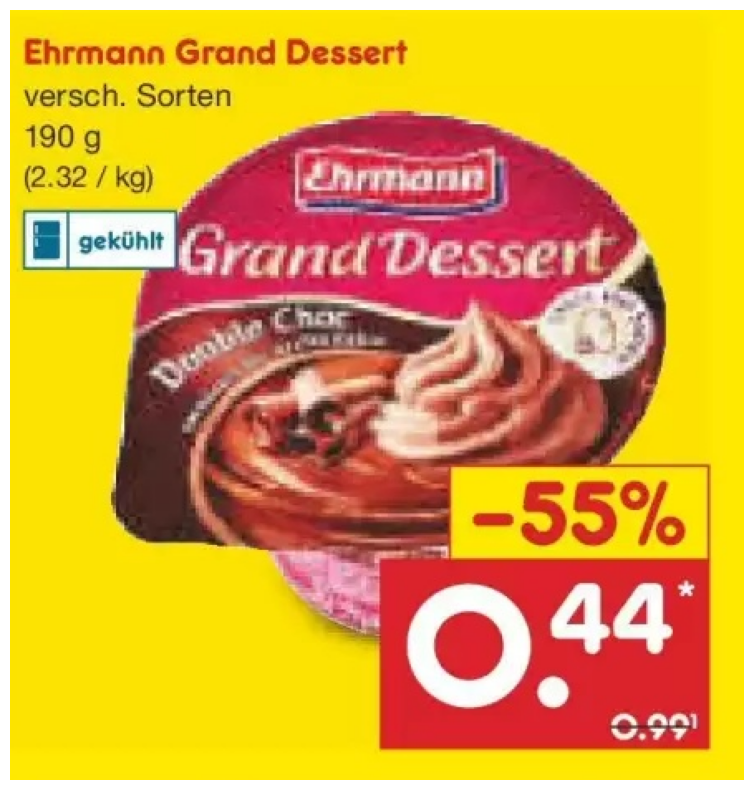

['Ehrmann Grand Dessert', 'versch: Sorten', '190 g', '32', 'kg)', 'Ennann', 'gekühlt', 'IGrand Dessert', 'Gods', '~559', '0.44', '5.s91']


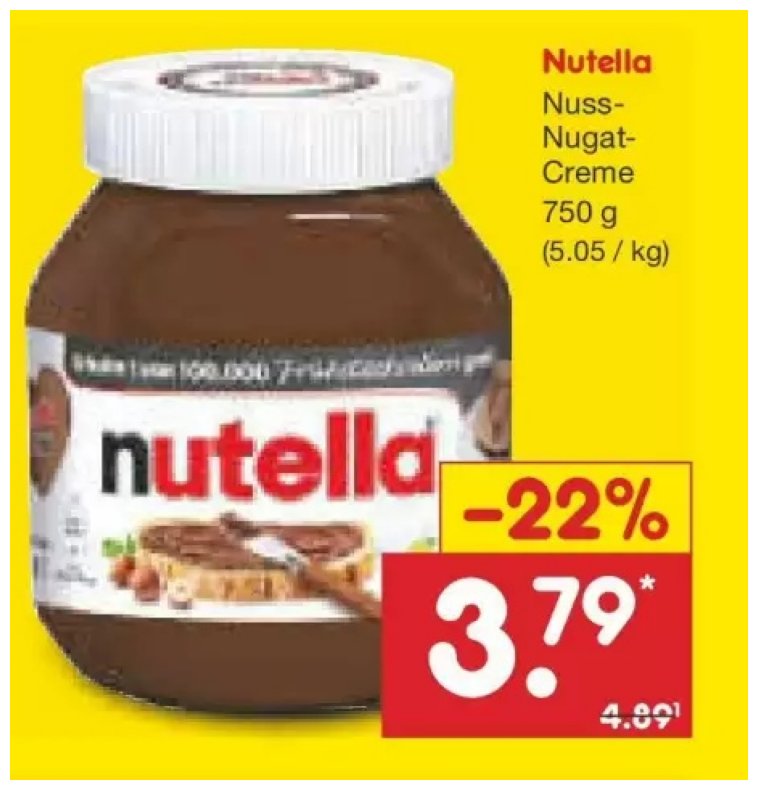

['Nutella', 'Nuss -', 'Nugat-', 'Creme', '750 g', '(5.05', 'kg)', 'nutelld', '~229', '379', '4.891']


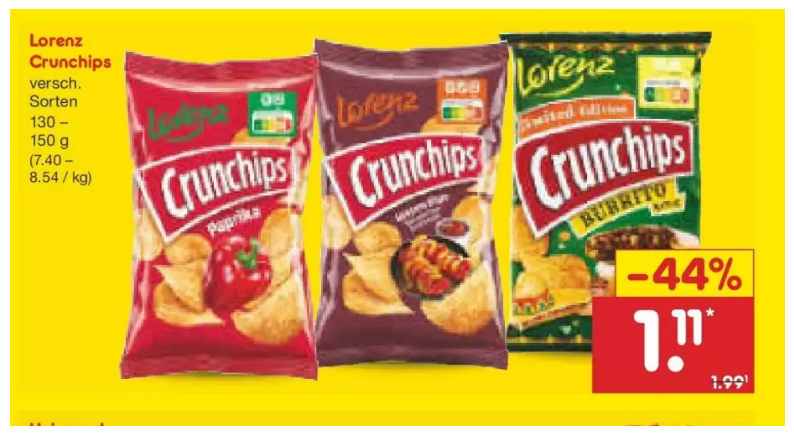

['Lorenz', 'Crunchips', 'versch.', '029', 'Sorten', '04', '130', 'L', '150 g', '(7.40', '8.54', 'kg)', '-449', '1,"', 'llorenz', 'bsiz', '(runchips]', '(runchipg', '(runchips _']


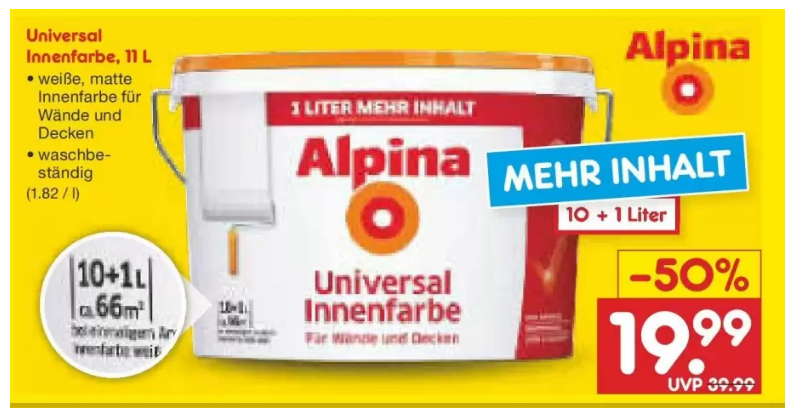

['Universal', 'Innenfarbe; 11 L', 'Alpina', 'weiße; matte', 'Innenfarbe für', 'Wände und', '1lrhehainhaLT', 'Decken', 'staschge-', 'Alpina', 'MEHR INHALT', '(1.82', '10', 'Liter', '10+1|', 'Universal', '~509', '0', '66m[', 'Innenfarbe', 'ralrlen', '1999', 'UVP 24.99']


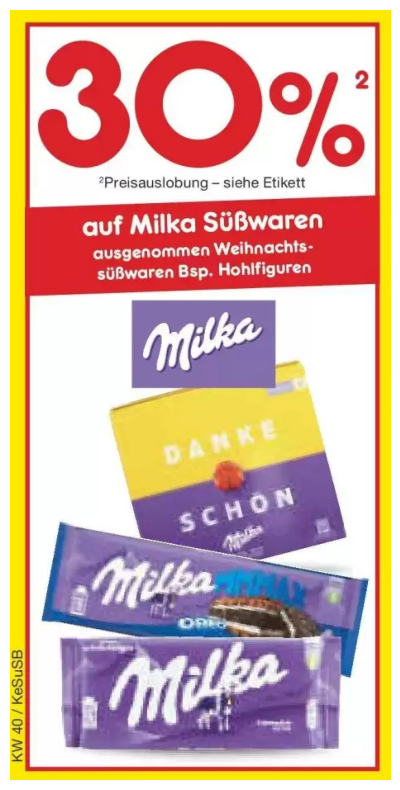

['30O9]', '?Preisauslobung', 'siehe Etikett', 'auf Milka Süßwaren', 'ausgenommen Weihnachts-', 'süßwaren Bsp. Hohlfiguren', 'Ontlba', 'g', '8', '9', '2', 'Ondlke', 'Daake', 'S€ hon', 'Ouilka']


In [11]:
import easyocr
reader = easyocr.Reader(['de','en'])

ocr_results = []
for i, ext in enumerate(extracted):
    plt.figure(figsize=(10, 10))
    plt.imshow(ext)
    plt.axis('off')
    plt.show()
    result = reader.readtext(ext, detail=0)
    ocr_results.append(result)
    print(result)

In [12]:
# from doctr.models import ocr_predictor

# model = ocr_predictor(pretrained=True)
# for i, ext in enumerate(extracted):
#     result = model([ext])
#     result.show()
#     print(result)

## NER

In [14]:
import spacy
from spacy import displacy

os.system("python -m spacy download en_core_web_sm")
ner_engine = spacy.load("en_core_web_sm")

In [15]:
for res in ocr_results:
    raw_text = " ".join(res)
    doc = ner_engine(raw_text)
    for word in doc.ents:
        print(word.text, word.label_)

Schnittbrötchen PERSON
10 Stück DATE
Einzelpreis PERSON
0.19 CARDINAL
10 CARDINAL
Unser Mehl PERSON
150 CARDINAL
Mühlen Angebot PERSON
Filialen ORG
Backofen GPE
489 CARDINAL
Ehrmann Grand Dessert PERSON
190 CARDINAL
32 kg QUANTITY
Ennann PERSON
0.44 CARDINAL
Nutella Nuss - Nugat- PERSON
750 CARDINAL
5.05 kg QUANTITY
379 4.891 CARDINAL
Lorenz Crunchips PERSON
04 130 CARDINAL
7.40 8.54 kg QUANTITY
1 CARDINAL
Universal Innenfarbe ORG
11 CARDINAL
L Alpina LOC
Decken ORG
Alpina MEHR INHALT PERSON
1.82 10 Liter DATE
66 CARDINAL
1999 DATE
UVP 24.99 ORG
30O9 CARDINAL
Preisauslobung GPE
Etikett PERSON
Milka Süßwaren ORG
Hohlfiguren Ontlba PERSON
8 CARDINAL
Ouilka ORG


## LLM

In [ ]:
SYSTEM_PROMPT=r"""
You are an advanced language model specialized in analyzing OCR-generated text to extract structured information. Below is the OCR result from a supermarket leaflet. Your task is to identify and extract the following attributes for each product mentioned:

Title/Name: The main name or title of the product.
Current Price: The current discounted or sale price of the product.
Original Price: The original price before any discount (if available).
Discount (%): The percentage discount applied (if stated or calculable).
Specification: Key details or descriptions about the product, such as weight, quantity, or other notable features.
Instructions:

Extract the information in a structured JSON format.
If any attribute is missing or unclear in the OCR text, return "N/A" for that field.
When calculating the discount percentage, round to the nearest whole number.
Focus on clarity and precision to ensure no relevant details are missed.
Example Input (OCR Text):
"Fresh Apples - 1kg
Now only $2.50 (Was $3.00)
Save 20%!

Laundry Detergent 2L
Special Price: $5.99
Original Price: $7.99

Premium Dark Chocolate
50% off!
Current Price: $4.00
Specification: 200g bar"

Example Output:

json
Copy code
[
  {
    "Title": "Fresh Apples",
    "Current Price": "$2.50",
    "Original Price": "$3.00",
    "Discount (%)": "20",
    "Specification": "1kg"
  },
  {
    "Title": "Laundry Detergent",
    "Current Price": "$5.99",
    "Original Price": "$7.99",
    "Discount (%)": "25",
    "Specification": "2L"
  },
  {
    "Title": "Premium Dark Chocolate",
    "Current Price": "$4.00",
    "Original Price": "N/A",
    "Discount (%)": "50",
    "Specification": "200g bar"
  }
]
"""


In [ ]:
def get_text(ocr_res):
    for block in ocr_res.pages[0].blocks:
        for line in block.lines:
            for word in line.words:
                yield word.value

In [ ]:
from doctr.models import ocr_predictor
from openai import OpenAI
client = OpenAI(base_url="http://localhost:5000/v1", api_key="lm-studio")
model = ocr_predictor(pretrained=True)

for i, ext in enumerate(extracted):
    result = model([ext])
    texts = list(get_text(result))
    print(texts)
    completion = client.chat.completions.create(
      model="lmstudio-community/Meta-Llama-3.1-8B-Instruct-GGUF",
      messages=[
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": f"""OCR Result:
                                        {texts}

                                        Output:

                                        This structured approach ensures clear and consistent extraction, which could integrate seamlessly with diffusion-based or other automated tools if needed later in your pipeline.
                                        """},
      ],
      temperature=0.3,
    )
    print(completion.choices[0].message.content)
    # import re
    # json_content = re.search(r"\{(?:[^{}])*\}", completion.choices[0].message.content)
    # if json_content:
    #     print(json_content.group(0))
    # else:
    #     print(completion.choices[0].message.content) 

c:\Users\ihett\Workspace\leaflets\.venv\Lib\site-packages\doctr\models\utils\pytorch.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(archive_pat

['Herta', 'Herta', 'Finesse', '-', 'Finesse', 'Aktion', 'PUTENBRUST', '9', 'GEPOKELT', '&', 'GEGART', 'SCHINKEN', '-', 'mit', 'Honig', 'verfeinert', 'feinwurzig', '149', '6N2', 'Herta', '', 'Oge', '-', '100ge', 'Herta', 'Finesse', 'verschiedene', 'Sorten,', 'Z.', 'B.', 'Putenbrust', 'mit', 'Honig,', 'Schinken', 'nauchzart', 'oder', 'Hahnchenbrust', 'mild', 'gerauchert,', '1', 'kg', '=', '14,90', '€,', '100', 'g', 'Packung']
